<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/bs_deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black-Scholes Partial Differential Equation (PDE)
The value of an option $V(S, t)$ satisfies the Black-Scholes PDE:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

### Initial and Boundary Conditions of the Black-Scholes PDE

The initial and boundary conditions for the Black-Scholes PDE depend on the type of derivative being priced, such as European call or put options. These conditions are necessary for solving the PDE and obtaining specific option prices. We will consider a Call option.

- $\textbf{Initial Condition}$ (at $t = T$):
    - $\text{Call: } V(S, T) = \max(S - K, 0)$ \\
- $\textbf{Boundary Conditions:}$
  - $V(0, t) = 0$ \\
  - $V(S, t) \to S - K e^{-r(T-t)} \quad \text{as } S \to \infty$

These conditions, combined with the Black-Scholes PDE, provide a complete specification for determining the price of the option.

## Implementation

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.1 MB/s eta 0:00:00


In [2]:
import deepxde as dde
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
# Define the Black-Scholes PDE
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return dy_t + 0.5 * sigma**2 * x[:, 0:1]**2 * dy_xx + r * x[:, 0:1] * dy_x - r * y

# Define the boundary and initial conditions
def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return np.maximum(x[:, 0:1] - K, 0)

# Normalize the input data
def normalize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

# Analytical solution for a European call option
def analytical_solution(x):
    S, t = x[:, 0:1], x[:, 1:2]
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)

# Parameters
sigma = 0.2  # volatility
r = 0.05     # risk-free interest rate
K = 50       # strike price
T = 1.0      # time to maturity

# Geometry and time domain
geom = dde.geometry.Interval(0, 100)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Boundary and initial conditions
bc = dde.DirichletBC(geomtime, func, boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

# Data
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160)

# Neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Model
model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.095466 s

'compile' took 0.811168 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.27e-04, 1.28e+03, 3.91e+02]    [7.27e-04, 1.28e+03, 3.91e+02]    []  
1000      [4.17e+00, 2.48e+01, 3.76e+00]    [4.17e+00, 2.48e+01, 3.76e+00]    []  
2000      [5.45e-01, 7.35e-01, 5.67e-01]    [5.45e-01, 7.35e-01, 5.67e-01]    []  
3000      [1.98e-01, 2.57e-01, 3.89e-01]    [1.98e-01, 2.57e-01, 3.89e-01]    []  
4000      [8.13e-02, 6.11e-03, 3.32e-01]    [8.13e-02, 6.11e-03, 3.32e-01]    []  
5000      [9.84e-02, 7.17e-02, 3.13e-01]    [9.84e-02, 7.17e-02, 3.13e-01]    []  
6000      [5.43e-02, 7.37e-03, 2.70e-01]    [5.43e-02, 7.37e-03, 2.70e-01]    []  
7000      [3.99e-02, 7.44e-03, 2.12e-01]    [3.99e-02, 7.44e-03, 2.12e-01]    []  
8000      [4.28e-02, 6.47e-03, 2.12e-01]    [4.28e-02, 6.47e-03, 2.12e-01]    []  
9000      [3.45e-02, 4.74e-03, 2.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


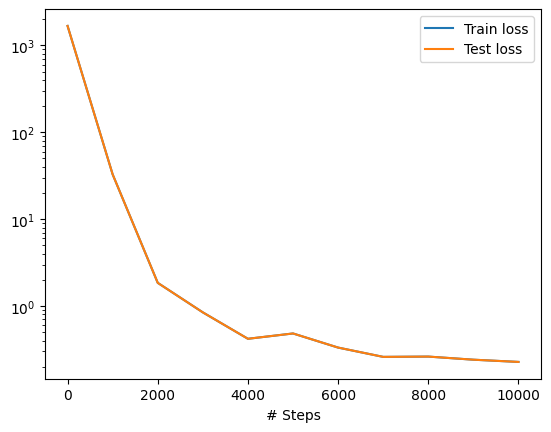

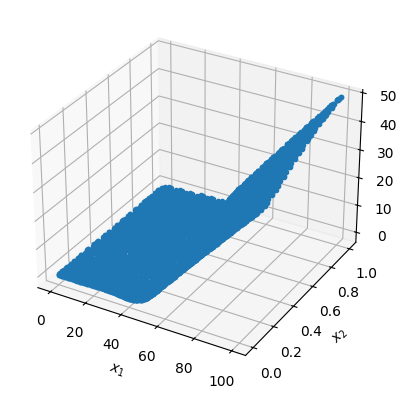

In [4]:
# Plot results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [5]:
# Avoid scientific notation in print statements
np.set_printoptions(suppress=True)

In [22]:
# Make predictions
X = geomtime.random_points(100)
X = X[np.argsort(X[:, 0])]
asset = X[:, 0].reshape(100, 1)

In [28]:
import torch
# Create a grid for prediction
S_pred = X[:, 0]
t_pred = X[:, 1]

S_pred_tensor = torch.tensor(S_pred.squeeze())
t_pred_tensor = torch.tensor(t_pred.squeeze())

S_grid_pred, t_grid_pred = torch.meshgrid(S_pred_tensor, t_pred_tensor,
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Make predictions using the trained model
y_pred = model.predict(torch.cat((S_flat, t_flat), dim=1))
y_pred = y_pred.reshape(100, 100)


# Compare with analytical solution
y_true = analytical_solution(torch.cat((S_flat, t_flat), dim=1))
y_true = y_true.reshape(100, 100)


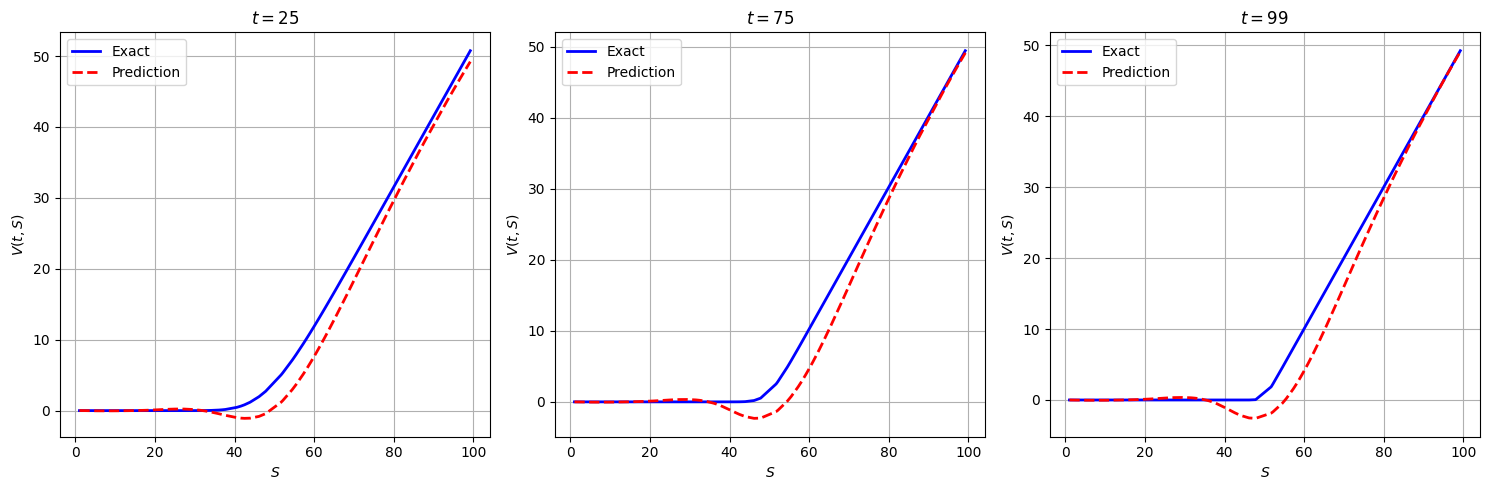

In [29]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 75, 99]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    y_pred_slice = y_pred[:, t_slice]

    # Compute exact solution
    y_true_slice = y_true[:,t_slice]

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(asset, y_true_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(asset, y_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$S$")
    plt.ylabel("$V(t, S)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
